In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# import plotly as py
# import cufflinks as cf
# from plotly.offline import iplot
# py.offline.init_notebook_mode(connected=True)
# cf.go_offline()

In [2]:
matches = pd.read_csv("../data/WorldCupMatches.csv")

In [3]:
matches.dropna(axis=0).tail(3)


,Year,Datetime,Stage,Stadium,City,Home Team Name,Home Team Goals,Away Team Goals,Away Team Name,Win conditions,Attendance,Half-time Home Goals,Half-time Away Goals,Referee,Assistant 1,Assistant 2,RoundID,MatchID,Home Team Initials,Away Team Initials
849,2014.0,09 Jul 2014 - 17:00,Semi-finals,Arena de Sao Paulo,Sao Paulo,Netherlands,0.0,0.0,Argentina,Argentina win on penalties (2 - 4),63267.0,0.0,0.0,C�neyt �AKIR (TUR),DURAN Bahattin (TUR),ONGUN Tarik (TUR),255955.0,300186490.0,NED,ARG
850,2014.0,12 Jul 2014 - 17:00,Play-off for third place,Estadio Nacional,Brasilia,Brazil,0.0,3.0,Netherlands,,68034.0,0.0,2.0,HAIMOUDI Djamel (ALG),ACHIK Redouane (MAR),ETCHIALI Abdelhak (ALG),255957.0,300186502.0,BRA,NED
851,2014.0,13 Jul 2014 - 16:00,Final,Estadio do Maracana,Rio De Janeiro,Germany,1.0,0.0,Argentina,Germany win after extra time,74738.0,0.0,0.0,Nicola RIZZOLI (ITA),Renato FAVERANI (ITA),Andrea STEFANI (ITA),255959.0,300186501.0,GER,ARG


In [4]:
data = matches
data = data[data["Year"] >= 1998]
data = data[data["Stage"].str.contains("Group")]
cols = ["Year", "Home Team Goals", "Away Team Goals"]
data = data[cols]
data.rename({"Home Team Goals":"Home_goals", "Away Team Goals":"Away_goals"}, axis=1, inplace=True)
data.head()
scores = [(0, 0), (1, 0), (1, 1), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2), (3, 3), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]
counts = []
for a, b in scores:
    mask = (data["Home_goals"] == a) & (data["Away_goals"] == b)
    count = len(data[mask])
    if a != b:
        mask = (data["Away_goals"] == a) & (data["Home_goals"] == b)
        count += len(data[mask])
    counts.append(count)
scores = [f"{a}-{b}" for a, b in scores]
df = pd.DataFrame(list(zip(scores, counts)), columns =['Score', 'Count'])
df.head()

,Score,Count
0,0-0,21
1,1-0,47
2,1-1,27
3,2-0,30
4,2-1,36


Text(0.5, 1.0, 'Frequency of scores')

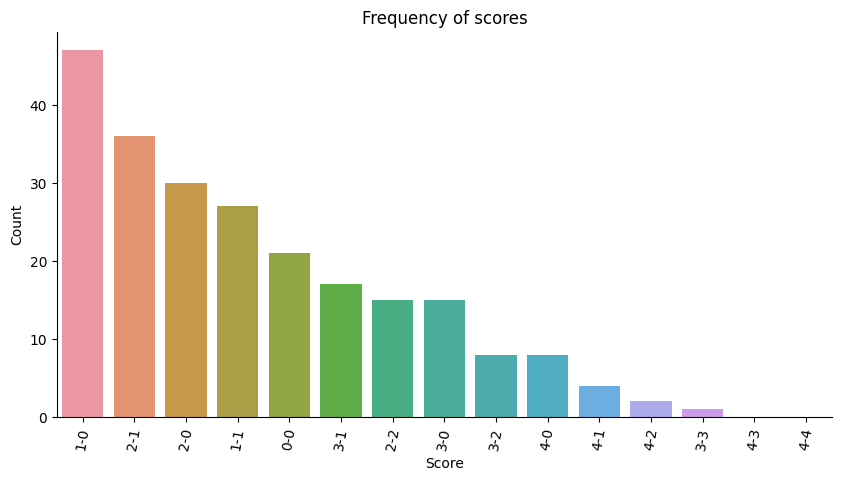

In [5]:
fig, ax = plt.subplots(figsize = (10, 5))
sns.despine(right = True)
g = sns.barplot(x = 'Score', y = 'Count', data = df.sort_values(by="Count", ascending=False))
g.set_xticklabels(g.get_xticklabels(), rotation = 80)
g.set_title('Frequency of scores')

Text(0.5, 1.0, 'Goal difference')

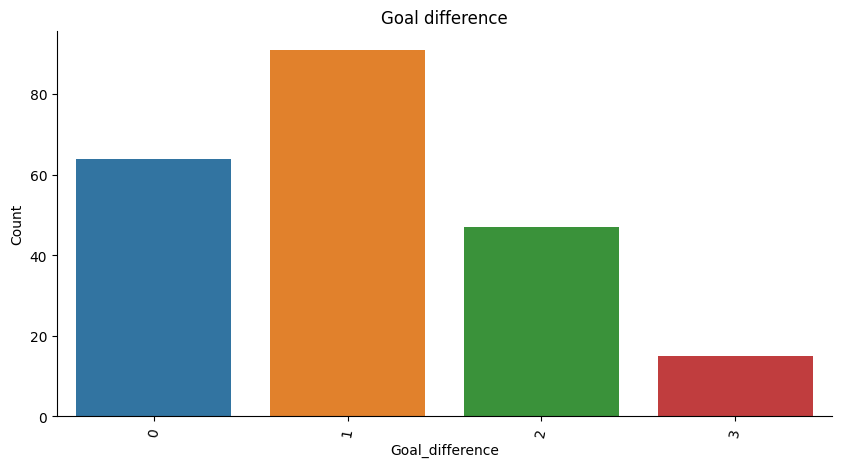

In [6]:
counts = []
goal_difference = []
for goal_diff, scores in [(0, [(0,0), (1,1), (2,2), (3,3)]),
                          (1, [(1, 0), (2, 1), (3, 2)]),
                          (2, [(2, 0), (3, 1)]),
                          (3, [(3, 0)])
                           ]:
    scores = [f"{a}-{b}" for a, b in scores]
    data = df[df['Score'].isin(scores)]
    sum = data["Count"].sum()
    counts.append(sum)
    goal_difference.append(goal_diff)
df_goal_diff = pd.DataFrame(list(zip(goal_difference, counts)), columns =['Goal_difference', 'Count'])
fig, ax = plt.subplots(figsize = (10, 5))
sns.despine(right = True)
g = sns.barplot(x = 'Goal_difference', y = 'Count', data = df_goal_diff.sort_values(by="Count", ascending=False))
g.set_xticklabels(g.get_xticklabels(), rotation = 80)
g.set_title('Goal difference')


# Rules
1. Correct prediction: 100
1. Correct winner, right goal balance: 70
1. Correct winner, wrong goal balance: 50

Multipliers
1. achtste finale: 1.5
1. kwartfinale: 2
1. halve finale: 2.5
1. troostfinale: 3.0
1. finale: 3.5

Cases and expected outcome:

In [18]:
total_games = df.Count.sum()
for prediction in df.Score.values:
    b = int(prediction.split("-")[0])
    a = int(prediction.split("-")[1])
    expected_score = 0
    goal_diff_prediction = abs(a-b)
    for outcome in df.Score.values:
        b = int(outcome.split("-")[0])
        a = int(outcome.split("-")[1])
        goal_diff_outcome = abs(a-b)
        frequency = df[df.Score == outcome].Count.values[0] / total_games
        # Go through 3 cases for rewarding points.
        # Case 1: correct prediction
        if prediction == outcome:
            if a == b:  # Draw
                expected_score += frequency * 100
            else:  # No draw, multiply with 0.5 for prediction of the right winner
                expected_score += 0.5 * frequency * 100
        # Case 2: correct winner, right goal balance:
        elif goal_diff_outcome == goal_diff_prediction:
            if a == b:  # Draw
                expected_score += frequency * 70
            else:  # No draw, multiply with 0.5 for prediction of the right winner
                expected_score += 0.5 * frequency * 70
        # Correct winner, wrong goal balance: 50
        elif a != b and goal_diff_prediction != 0:  # There is a winner and this was predicted
            expected_score += 0.5 * frequency * 50
    df.loc[df.Score==prediction, ["Expected_score"]] = expected_score
df.head()

,Score,Count,Expected_score
0,0-0,21,22.121212
1,1-0,47,25.064935
2,1-1,27,22.900433
3,2-0,30,22.142857
4,2-1,36,24.350649


Text(0.5, 1.0, 'Expected number of points per predicted score.')

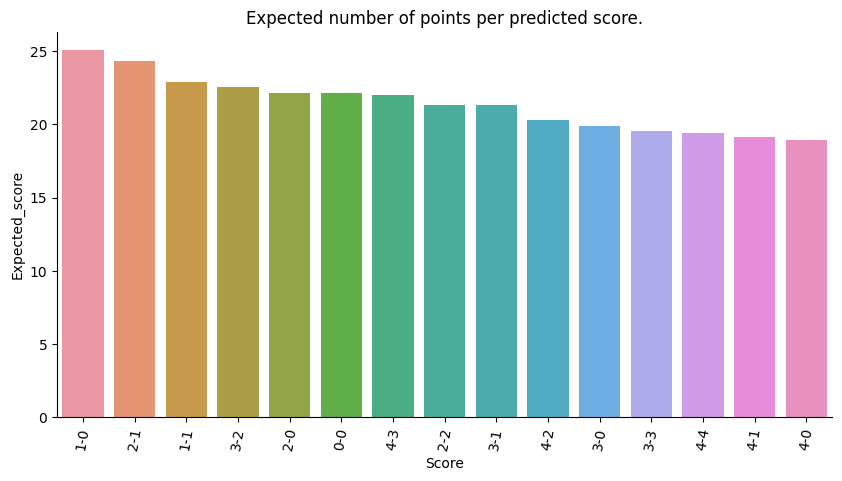

In [19]:
fig, ax = plt.subplots(figsize = (10, 5))
sns.despine(right = True)
g = sns.barplot(x = 'Score', y = 'Expected_score', data = df.sort_values(by="Expected_score", ascending=False))
g.set_xticklabels(g.get_xticklabels(), rotation = 80)
g.set_title('Expected number of points per predicted score.')

# Conclusions
* A one goal difference game is most occuring.
* A prediction of 1-0 has the highest expeted return, followed by 2-0 and then 1-1.

# Suggested strategy:
* If there's a larger skill difference, predict 1-0 or 2-1 to mix things up.
* If there's little skill difference, predict 1-1.

Strange looking scores that are still quite good are: 3-2, 4-3. As long as there is one goal difference. 